# Isolated skyrmion in confined helimagnetic nanostructure

**Authors**: Marijan Beg, Marc-Antonio Bisotti, Weiwei Wang, Ryan Pepper, David Cortes-Ortuno

**Date**: 26 June 2016 (Updated 24 Jan 2019)

This notebook can be downloaded from the github repository, found [here](https://github.com/computationalmodelling/fidimag/blob/master/doc/ipynb/isolated_skyrmion.ipynb).

## Problem specification

A thin film disk sample with thickness $t=10 \,\text{nm}$ and diameter $d=100 \,\text{nm}$ is simulated. The material is FeGe with material parameters [1]:

- exchange energy constant $A = 8.78 \times 10^{-12} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 3.84 \times 10^{5} \,\text{A/m}$, and
- Dzyaloshinskii-Moriya energy constant $D = 1.58 \times 10^{-3} \,\text{J/m}^{2}$.

It is expected that when the system is initialised in the uniform out-of-plane direction $\mathbf{m}_\text{init} = (0, 0, 1)$, it relaxes to the isolated Skyrmion (Sk) state (See Supplementary Information in Ref. 1). (Note that LLG dynamics is important, which means that artificially disable the precession term in LLG may lead to other states).

## Simulation using the LLG equation

In [1]:
from fidimag.micro import Sim
from fidimag.common import CuboidMesh
from fidimag.micro import UniformExchange, Demag, DMI
from fidimag.common import plot
import time
%matplotlib inline

The cuboidal thin film mesh which contains the disk is created:

In [2]:
d = 100  # diameter (nm)
t = 10  # thickness (nm)

# Mesh discretisation.
dx = dy  = 2.5  # nm
dz = 2

mesh = CuboidMesh(nx=int(d/dx), ny=int(d/dy), nz=int(t/dz), dx=dx, dy=dy, dz=dz, unit_length=1e-9)

Since the disk geometry is simulated, it is required to set the saturation magnetisation to zero in the regions of the mesh outside the disk. In order to do that, the following function is created:

In [3]:
def Ms_function(Ms):
    def wrapped_function(pos):
        x, y, z = pos[0], pos[1], pos[2]
    
        r = ((x-d/2.)**2 + (y-d/2.)**2)**0.5  # distance from the centre
    
        if r <= d/2:
            # Mesh point is inside the disk.
            return Ms
        else:
            # Mesh point is outside the disk.
            return 0
    return wrapped_function

To reduce the relaxation time, we define a state using a python function.

In [4]:
def init_m(pos):
    x,y,z = pos
    x0, y0 = d/2., d/2.
    r = ((x-x0)**2 + (y-y0)**2)**0.5
    
    if r<10:
        return (0,0, 1)
    elif r<30:
        return (0,0, -1)
    elif r<60:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

Having the magnetisation saturation function, the simulation object can be created:

In [5]:
# FeGe material paremeters.
Ms = 3.84e5  # saturation magnetisation (A/m)
A = 8.78e-12  # exchange energy constant (J/m)
D = 1.58e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
alpha = 1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ration (m/As)

# Create simulation object.
sim = Sim(mesh)
# sim = Sim(mesh, driver='steepest_descent')
sim.Ms = Ms_function(Ms)
sim.driver.alpha = alpha
sim.driver.gamma = gamma

# Add energies.
sim.add(UniformExchange(A=A))
sim.add(DMI(D=D))
sim.add(Demag())

# Since the magnetisation dynamics is not important in this stage,
# the precession term in LLG equation can be set to artificially zero.
# sim.driver.do_precession = False

# Initialise the system.
sim.set_m(init_m)

This is the initial configuration used before relaxation:

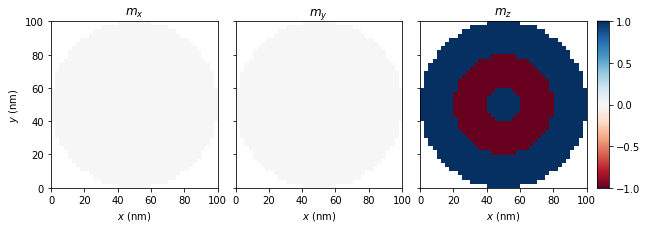

In [6]:
plot(sim, component='all', z=0.0, cmap='RdBu')

Now the system is relaxed to find a metastable state of the system:

In [7]:
# Relax the system to its equilibrium.
start = time.time()
sim.driver.relax(dt=1e-13, stopping_dmdt=0.1, max_steps=10000,
                 save_m_steps=None, save_vtk_steps=None, printing=False)
end = time.time()

In [8]:
#NBVAL_IGNORE_OUTPUT
print('Timing: ', end - start)

Timing:  77.00890803337097


In [9]:
sim.save_vtk()

The magnetisation components of obtained equilibrium configuration can be plotted in the following way:

We plot the magnetisation at the bottom of the sample:

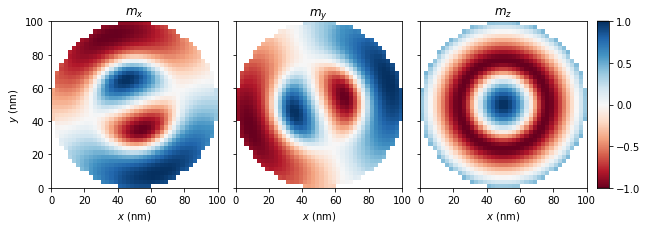

In [10]:
plot(sim, component='all', z=0.0, cmap='RdBu')

and at the top of the sample:

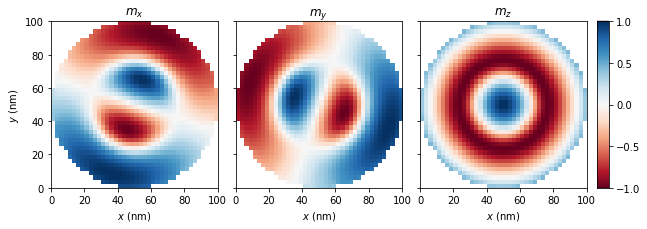

In [11]:
plot(sim, component='all', z=10.0, cmap='RdBu')

and we plot the xy spin angle through the middle of the sample:

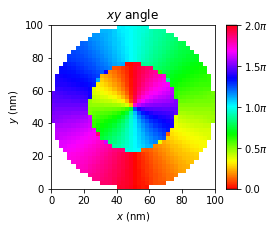

In [12]:
plot(sim, component='angle', z=5.0, cmap='hsv')

## Simulation using Steepest Descent

An alternative method for the minimisation of the energy is using a SteepestDescent method:

In [13]:
# Create simulation object.
sim = Sim(mesh, driver='steepest_descent')
sim.Ms = Ms_function(Ms)
sim.driver.gamma = gamma

# Add energies.
sim.add(UniformExchange(A=A))
sim.add(DMI(D=D))
sim.add(Demag())

# The maximum timestep:
sim.driver.tmax = 1

# Initialise the system.
sim.set_m(init_m)

In this case the driver has a `minimise` method

In [14]:
start = time.time()
sim.driver.minimise(max_steps=10000, stopping_dm=0.5e-4, initial_t_step=1e-2)
end = time.time()

#0    max_tau=0.01     max_dm=0.0477    
#1000 max_tau=0.01     max_dm=0.0022    
#2000 max_tau=0.01     max_dm=0.000592  
#3000 max_tau=0.01     max_dm=0.000327  
#4000 max_tau=0.01     max_dm=0.000179  
#5000 max_tau=0.01     max_dm=9.82e-05  
#6000 max_tau=0.01     max_dm=5.43e-05  
#6141 max_tau=0.01     max_dm=5e-05     


In [15]:
#NBVAL_IGNORE_OUTPUT
print('Timing: ', end - start)

Timing:  67.3641722202301


And the final state is equivalent to the one found with the LLG technique

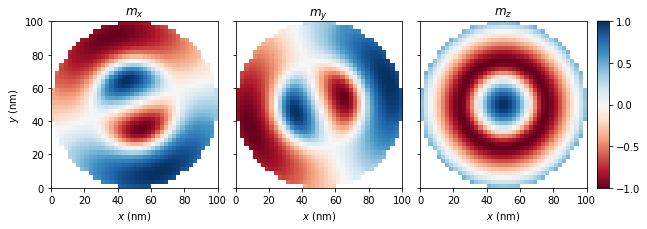

In [16]:
plot(sim, component='all', z=0.0, cmap='RdBu')

## References

[1] Beg, M. et al. Ground state search, hysteretic behaviour, and reversal mechanism of skyrmionic textures in confined helimagnetic nanostructures. *Sci. Rep.* **5**, 17137 (2015).